<a href="https://colab.research.google.com/github/PsorTheDoctor/artificial-intelligence/blob/master/modern_approach/text_to_3d/point_e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Point-e: text to point cloud

In [ ]:
!git clone https://github.com/openai/point-e.git
%cd point-e

In [ ]:
!pip install -q -e .

In [13]:
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def create_model(model_name):
  print('Creating {} model...'.format(model_name))
  model = model_from_config(MODEL_CONFIGS[model_name], device)
  model.eval()
  diffusion = diffusion_from_config(DIFFUSION_CONFIGS[model_name])
  print('Downloading {} checkpoint...'.format(model_name))
  model.load_state_dict(load_checkpoint(model_name, device))
  return model, diffusion

base_model, base_diffusion = create_model('base40M-textvec')
upsampler_model, upsampler_diffusion = create_model('upsample')

Creating base40M-textvec model...
Creating upsample model...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

In [16]:
sampler = PointCloudSampler(
    device=device, 
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', '')
)

In [38]:
prompt = 'a kangaroo'

samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
  samples = x 

0it [00:00, ?it/s]

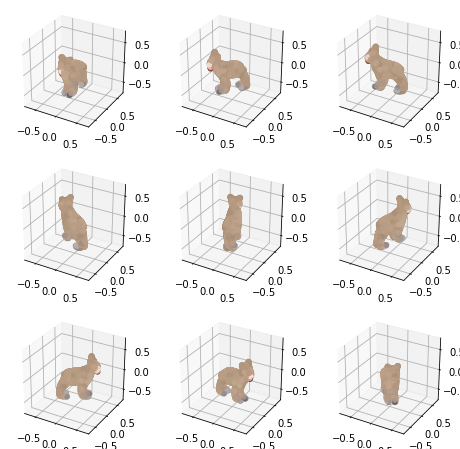

In [40]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75), (0.75, 0.75, 0.75)))

In [32]:
print(pc.coords.shape)
print(pc.channels.keys())

(4096, 3)
dict_keys(['R', 'G', 'B'])


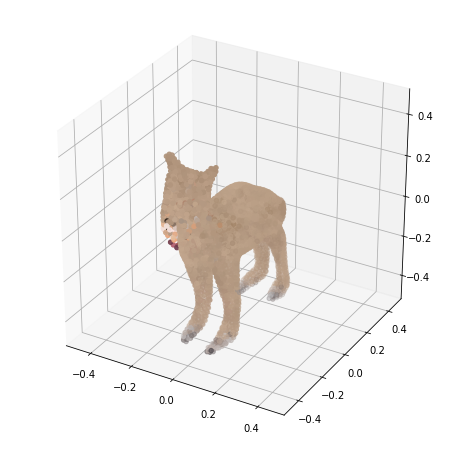

In [41]:
fig = plot_point_cloud(pc, grid_size=1, fixed_bounds=((-0.5, -0.5, -0.5), (0.5, 0.5, 0.5)))